In [33]:
# import 
import numpy as np 
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import tree

In [34]:
# Read node data from file 
# The result is dic with the name and their position 

with open('points.txt', 'r') as f:
    
    nodes = {}
    Nodes = []
    
    for line in f.readlines():
        
        name, location_part = line.strip().split(';')
        location = location_part.strip()[1:-1].split(',')
        location = (int(location[0]), -1 * int(location[1]))  # -1 because the ref is the top left corner
        nodes[name] = location
        Nodes.append(name)

#------------------------------------------------------------------------------------------------------------------

already = [] 

# Read edge data from file
with open('curves.txt', 'r') as f:
    
    edges = {}
    
    for line in f.readlines():
        
        #------------------------------------------------------------------------------------------------------------------
        # Retrieve the informations of the edge
        
        num, ends_part, length = line.strip().split(';')

        length = round(float(length), 3)

        node1, node2 = ends_part.strip().split(',')
        
        #------------------------------------------------------------------------------------------------------------------
        # Creates a tuple. As the edge is a road that could be taken in both direction, both edges must be checked

        edge = (node1,node2)
        edge_bis = (node2, node1)

        #------------------------------------------------------------------------------------------------------------------
        # If none direction is already in the list, we add an entry in the dic with the length and add it to the list 
        
        if edge not in already and edge_bis not in already : 
            edges[edge] = float(length)
            already.append(edge)

        #------------------------------------------------------------------------------------------------------------------
        # If there's already in the list, we check if the new edge considered as a length lower than the previous one 
        # If it's the case, we replace the length in the dictionnary
        
        else :
            if edge in already : 
                if length < edges[edge] : 
                    edges[edge] = length
            if edge_bis in already : 
                if length < edges[edge_bis] : 
                    edges[edge_bis] = length 

#------------------------------------------------------------------------------------------------------------------
# Create distance matrix between the nodes 

names = [] 
for name in nodes.keys() : 
    names.append(name)

dists = [[0]*len(nodes) for _ in range(len(nodes))]

for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):

        edge = (names[i], names[j])
        edge_bis = (names[j], names[i])

        if edge in edges.keys() :
            dists[i][j] = edges[edge]
            dists[j][i] = edges[edge]
            
        elif edge_bis in edges.keys() : 
            dists[i][j] = edges[edge_bis]
            dists[j][i] = edges[edge_bis]
            
        else : 
            dists[i][j] = 10**15 #float('inf')
            dists[j][i] = 10**15 #float('inf')
            
dists = np.array(dists)

#------------------------------------------------------------------------------------------------------------------

# Create a DataFrame from the distance matrix
df = pd.DataFrame(dists, columns=names, index=names)

# Display the DataFrame
print()
print("Shorter direct access between the points (symmetric) \n")
print(df)


Shorter direct access between the points (symmetric) 

                        entry_1        tapirs       rapaces     chouettes  \
entry_1            0.000000e+00  1.000000e+15  1.000000e+15  1.000000e+15   
tapirs             1.000000e+15  0.000000e+00  2.472800e+01  1.000000e+15   
rapaces            1.000000e+15  2.472800e+01  0.000000e+00  6.697300e+01   
chouettes          1.000000e+15  1.000000e+15  6.697300e+01  0.000000e+00   
loups              1.000000e+15  2.173350e+02  1.000000e+15  1.000000e+15   
...                         ...           ...           ...           ...   
mangoustes         1.000000e+15  1.000000e+15  1.000000e+15  1.000000e+15   
couscous_celebes   1.000000e+15  1.000000e+15  1.000000e+15  1.000000e+15   
ara                1.132070e+02  1.000000e+15  1.000000e+15  1.000000e+15   
lamas_dromadaires  1.000000e+15  1.000000e+15  1.000000e+15  4.214200e+01   
loutres            1.000000e+15  1.000000e+15  1.000000e+15  1.000000e+15   

                   

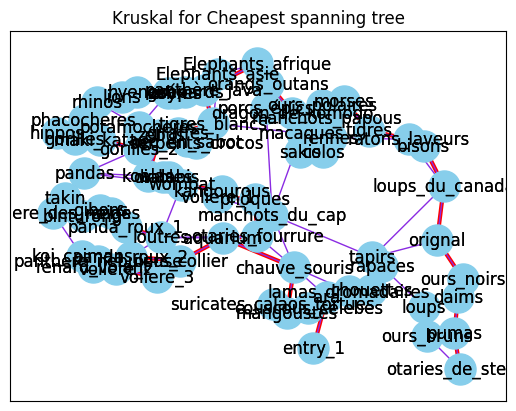

<Figure size 640x480 with 0 Axes>

In [35]:
# Kruskal to find the minimum spanning edges tree using kruskal, prim or brunovsky

node1, node2 = names[0], names[-1]

G_complete = nx.Graph()

# Add the nodes
for name in nodes.keys(): 
    G_complete.add_node(name, pos=nodes[name])

# Add edges with weights from the distance matrix
for i in range(len(names)):
    for j in range(i+1, len(names)):  # Only consider each pair of nodes once
        G_complete.add_edge(names[i], names[j], weight=dists[i][j])

mst = tree.minimum_spanning_edges(G_complete, algorithm='kruskal')
edgelist = list(mst)

# Create an empty graph
G_kruskal = nx.Graph()

# Add the nodes
for name in nodes.keys(): 
    G_kruskal.add_node(name, pos=nodes[name])

# Add edges with weights from the distance matrix
for i in range(len(names)):
    for j in range(i+1, len(names)):  # Only consider each pair of nodes once
        if dists[i][j] != 10**15:  # Only add an edge if a distance exists
            G_kruskal.add_edge(names[i], names[j], weight=dists[i][j])
            

# Get node positions from the graph
node_positions = {node: data['pos'] for node, data in G_kruskal.nodes(data=True)}
            
position = nx.spring_layout(G_kruskal, pos=node_positions, fixed=node_positions.keys())

# Create dictionaries for node and edge labels
node_labels = {node: node for node in G_kruskal.nodes()}
edge_labels = {(u, v): round(data['weight'], 3) for u, v, data in G_kruskal.edges(data=True)}

plt.figure()

# Draw the route
nx.draw_networkx(
    G_kruskal,
    position,
    with_labels=True,
    edgelist=edgelist,
    edge_color="red",
    node_size=200,
    width=3,
)

nx.draw_networkx_nodes(G_kruskal, position, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G_kruskal, position, edge_color='blueviolet')
nx.draw_networkx_labels(G_kruskal, position, labels=node_labels, font_size=12, font_color='black')
# nx.draw_networkx_edge_labels(G_kruskal, position, edge_labels=edge_labels, font_size=10)

plt.title("Kruskal for Cheapest spanning tree")
plt.show()
plt.savefig("kruskal.pdf")

In [36]:


#--------------------------------------------------------------------------------------------------------------------

"""Simple Travelling Salesperson Problem (TSP) between cities."""

def round_matrix(matrix):
    return [[round(element) for element in row] for row in matrix]

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = round_matrix(dists)
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    route = []
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = ""
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f"{Nodes[manager.IndexToNode(index)]} -> "
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        route.append(Nodes[manager.IndexToNode(index)])
    plan_output += f" {Nodes[manager.IndexToNode(index)]}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}\n"
    return route,plan_output

"""Entry point of the program."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
sol,output = print_solution(manager, routing, solution)

Objective: 6000000000004784
entry_1 -> ara -> lamas_dromadaires -> chouettes -> rapaces -> tapirs -> loups -> ours_bruns -> otaries_de_steller -> pumas -> daims -> ours_noirs -> orignal -> loups_du_canada -> bisons -> ratons_laveurs -> tigres -> morses -> ours_polaires -> manchots_papous -> rennes -> sakis -> Elephants_afrique -> orangs_outans -> porcs_épics -> dragon_de_komodo -> macaques -> colos -> potamocheres -> zébus -> koalas -> diables -> walabis -> wombat -> kangourous -> voliere_1 -> manchots_du_cap -> phoques -> otaries_fourrure -> chauve_souris -> aquarium -> ours_collier -> loutres -> panda_roux_1 -> suricates_calaos_tortues -> mangoustes -> couscous_celebes -> cerfs -> gibons -> binturong -> takin -> panthere_des_neiges -> koi_caimans -> renard_volant -> panthere_nebuleuse -> voliere_2 -> panda_roux_2 -> voliere_3 -> pandas -> gorilles_2 -> maki_katas -> gorilles -> hippos -> phacocheres -> rhinos -> lions -> hyenes -> oryx -> zebres -> guépards -> panthère_java -> Elepha

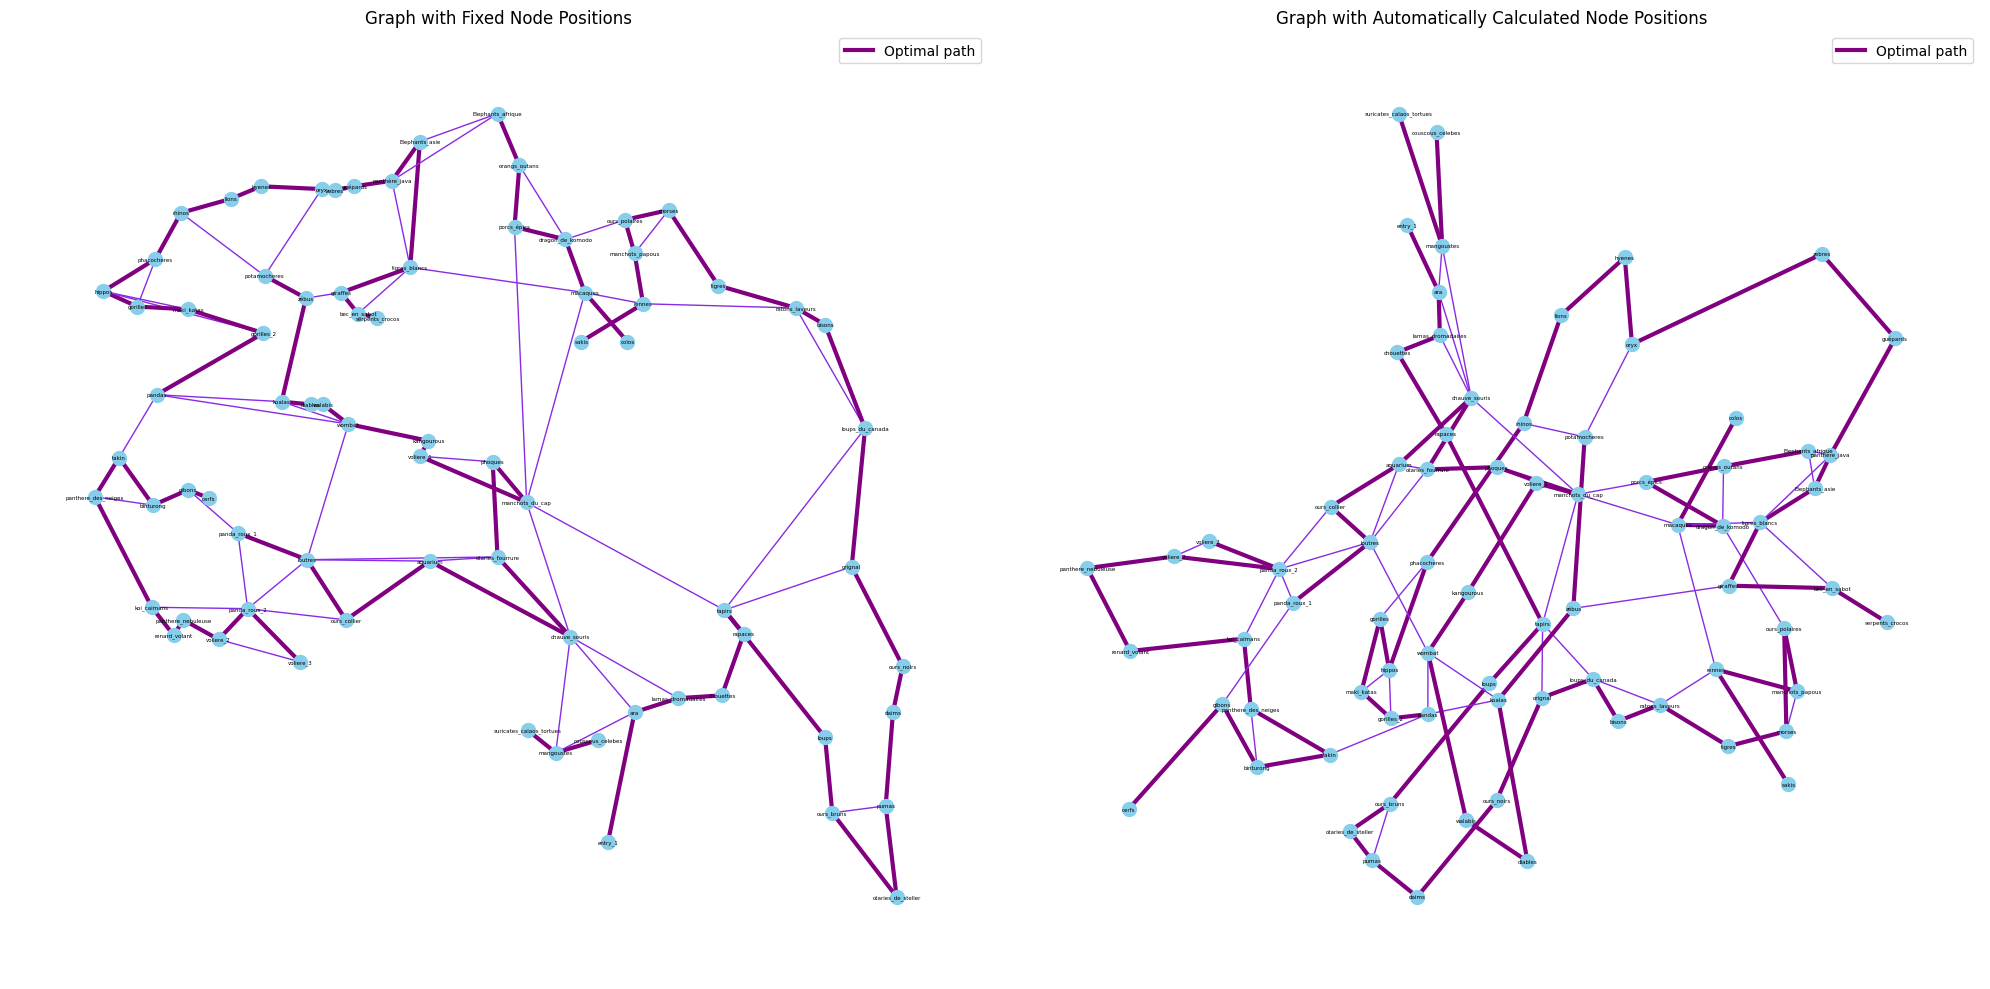

<Figure size 640x480 with 0 Axes>

In [37]:
# Create an empty graph
G = nx.Graph()

# Add the nodes
for name in nodes.keys(): 
    G.add_node(name, pos=nodes[name])

# Add edges with weights from the distance matrix
for i in range(len(names)):
    for j in range(i+1, len(names)):  # Only consider each pair of nodes once
        if dists[i][j] != 10**15:  # Only add an edge if a distance exists
            G.add_edge(names[i], names[j], weight=dists[i][j])

# Get node positions from the graph
node_positions = {node: data['pos'] for node, data in G.nodes(data=True)}

# Create dictionaries for node and edge labels
node_labels = {node: node for node in G.nodes()}
edge_labels = {(u, v): round(data['weight'], 3) for u, v, data in G.edges(data=True)}

#------------------------------------------------------------------------------------------------------------------

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Create a list of edges from the node list
edges_to_highlight = [(sol[i], sol[i + 1]) for i in range(len(sol) - 1)]
edges_to_highlight.append((sol[-1], sol[0]))  # Add the edge between the last and the first node

# Create a list of colors and widths for each edge
edge_colors = []
edge_widths = []
for n1, n2 in G.edges():
    if (n1, n2) in edges_to_highlight or (n2, n1) in edges_to_highlight:
        edge_colors.append('purple')
        edge_widths.append(3.0)  # Highlighted edges are wider
    else:
        edge_colors.append('blueviolet')
        edge_widths.append(1.0)  # Non-highlighted edges are thinner

#------------------------------------------------------------------------------------------------------------------

# Draw the graph with fixed node positions
position = nx.spring_layout(G, pos=node_positions, fixed=node_positions.keys())
nx.draw_networkx_nodes(G, position, node_color='skyblue', node_size=100, ax=axs[0])
nx.draw_networkx_edges(G, position, edge_color=edge_colors, ax=axs[0], width=edge_widths)
nx.draw_networkx_labels(G, position, labels=node_labels, font_size=4, font_color='black', ax=axs[0])
#nx.draw_networkx_edge_labels(G, position, edge_labels=edge_labels, font_size=10, ax=axs[0])
axs[0].set_title('Graph with Fixed Node Positions')
axs[0].axis('off')

#------------------------------------------------------------------------------------------------------------------

# Draw the graph with automatically calculated node positions
position = nx.spring_layout(G)
nx.draw_networkx_nodes(G, position, node_color='skyblue', node_size=100, ax=axs[1])
nx.draw_networkx_edges(G, position, edge_color=edge_colors, ax=axs[1], width=edge_widths)
nx.draw_networkx_labels(G, position, labels=node_labels, font_size=4, font_color='black', ax=axs[1])
#nx.draw_networkx_edge_labels(G, position, edge_labels=edge_labels, font_size=10, ax=axs[1])
axs[1].set_title('Graph with Automatically Calculated Node Positions')
axs[1].axis('off')

#------------------------------------------------------------------------------------------------------------------

# Add a legend
axs[0].plot([], [], color='purple', linewidth=3.0, label='Optimal path')
axs[0].legend(loc='upper right')
axs[1].plot([], [], color='purple', linewidth=3.0, label='Optimal path')
axs[1].legend(loc='upper right')

# Add text at the bottom of the figure
#fig.text(0.5, 0.02, output, ha='center', va='center', fontsize = 14)

# Display the graphs
plt.tight_layout()
plt.show()
plt.savefig('Graph_result.pdf')